## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px 

default_figsize = (12.8, 4.8)

## Data

### Household Demographic

In [ ]:
# Household demographics
df_household = pd.read_csv('dunnhumby/hh_demographic.csv', sep = ',')

#### Data Cleaning

In [ ]:
# correct dtypes
df_household['MARITAL_STATUS_CODE'] = df_household['MARITAL_STATUS_CODE'].astype('category')
df_household['HOMEOWNER_DESC'] =  df_household['HOMEOWNER_DESC'].astype('category')
df_household['HH_COMP_DESC'] = df_household['HH_COMP_DESC'].astype('category')
df_household['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(df_household['HOUSEHOLD_SIZE_DESC'].values, categories=['1', '2', '3', '4', '5+'], ordered=True)
df_household['KID_CATEGORY_DESC'] = pd.Categorical(df_household['KID_CATEGORY_DESC'].values, categories=['None/Unknown', '1', '2', '3+'], ordered=True)

# merge some income categories
cat_to_combine_over100K = ["100-124K", "125-149K", "150-174K", "175-199K", "200-249K", "250K+"]
cat_to_combine_under35K = ["Under 15K", "15-24K", "25-34K"]
def combine_cat_income(x):
    if x in cat_to_combine_over100K:
        return "100K+" 
    elif x in cat_to_combine_under35K:
        return "Under 35K"
    else: 
        return x
    
df_household['INCOME_DESC'] = df_household['INCOME_DESC'].apply(combine_cat_income)

# merge some age categories
cat_to_combine_over55 = ["55-64", "65+"]
cat_to_combine_under35 = ["19-24", "25-34"]
def combine_cat_age(x):
    if x in cat_to_combine_over55:
        return "55+" 
    elif x in cat_to_combine_under35:
        return "19-34"
    else: 
        return x
    
df_household['AGE_DESC'] = df_household['AGE_DESC'].apply(combine_cat_age)

# correct dtypes
df_household['INCOME_DESC'] = pd.Categorical(df_household['INCOME_DESC'].values, categories=['Under 35K', '35-49K', '50-74K', '75-99K', '100K+'], ordered=True)
df_household['AGE_DESC'] = pd.Categorical(df_household['AGE_DESC'].values, categories=['19-34', '35-44', '45-54', '55+'], ordered=True)

### Products

In [39]:
df_products = pd.read_csv('dunnhumby/product.csv', sep = ',')
df_food_products = pd.read_csv('data/food_products.csv')
df_meat_products = pd.read_csv('data/meat_products.csv')
df_veggies_products = pd.read_csv('data/vegetables_products.csv')

### Transactions

In [40]:
spent_by_household = pd.read_csv("data/spent_by_household.csv")

df_transactions = pd.read_csv("data/clean_transactions.csv")
df_food_transactions = pd.read_csv("data/food_transactions.csv")

df_pure_meat = pd.read_csv('data/pure_meat_products.csv')
df_veggies_prducts = pd.read_csv('data/vegetables_products.csv')
df_products = pd.read_csv("dunnhumby/product.csv")

## Distribution of Demographics

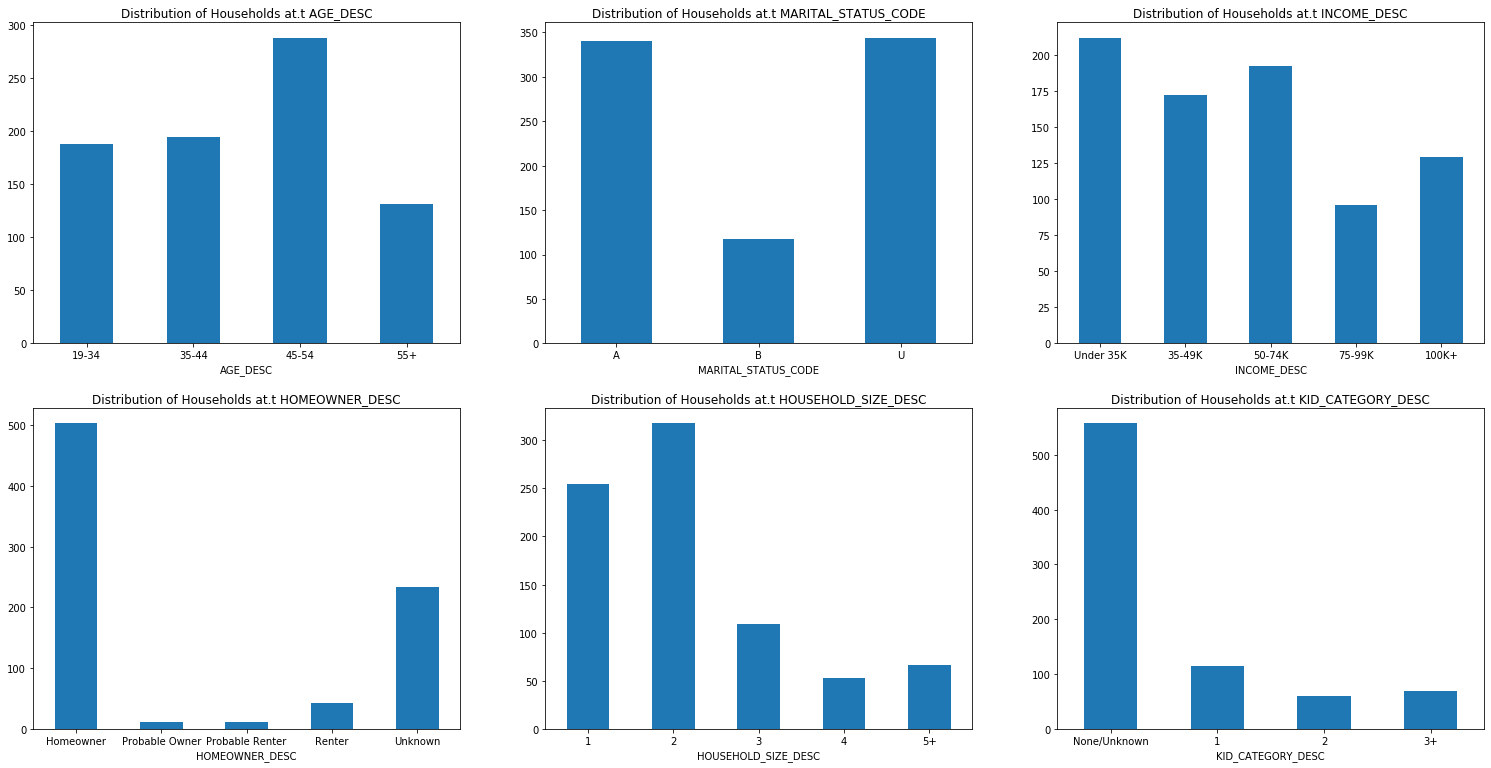

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, n in enumerate(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']):
    df_household.groupby(n)['household_key'].count().plot.bar(ax=axes[i // 3,i % 3], title='Distribution of Households at.t ' + n)
    axes[i // 3,i % 3].set_xticklabels(axes[i // 3,i % 3].get_xticklabels(), rotation=0)
    

## Analysis

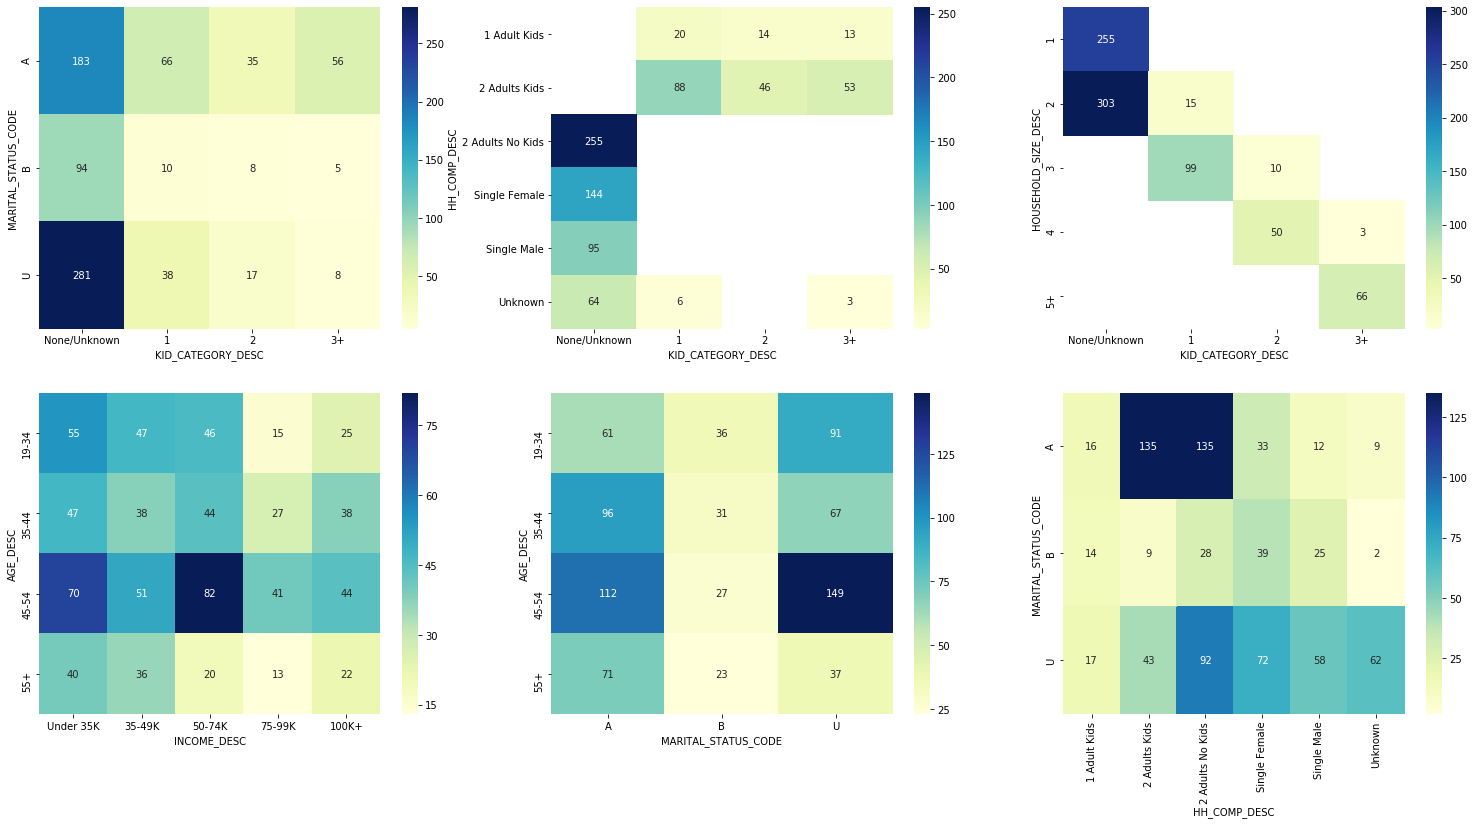

In [4]:
tuples = [ ('MARITAL_STATUS_CODE', 'KID_CATEGORY_DESC'),
 ('HH_COMP_DESC', 'KID_CATEGORY_DESC'),
 ('HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'),
 ('AGE_DESC', 'INCOME_DESC'),
 ('AGE_DESC', 'MARITAL_STATUS_CODE'),
 ('MARITAL_STATUS_CODE', 'HH_COMP_DESC')]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

for i, t in enumerate(tuples):
    df_dummy = df_household.groupby([t[0], t[1]]).count()\
        .reset_index().pivot(index= t[0], columns= t[1], values='household_key')
    
    sns.heatmap(df_dummy, annot=True, fmt=".0f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i // 3,i % 3])
    
    b, t = axes[i // 3,i % 3].set_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    axes[i // 3,i % 3].set_ylim(b, t) # update the ylim(bottom, top) values

In [17]:
spent_by_household

,Unnamed: 0,household_key,paid_meat,paid_food,number_of_active_weeks,avg_spending_per_week,paid_veggies,avg_spending_meat_per_week,ratio_spent_for_meat,avg_spending_veggies_per_week,ratio_spent_for_veggies
0,0,1,380.95,2812.21,67,41.973284,292.81,5.685821,0.135463,4.370299,0.104121
1,1,2,225.75,1082.74,31,34.927097,58.14,7.282258,0.208499,1.875484,0.053697
2,2,3,567.90,1711.78,36,47.549444,41.01,15.775000,0.331760,1.139167,0.023958
3,3,4,177.87,679.48,25,27.179200,9.70,7.114800,0.261774,0.388000,0.014276
4,4,5,126.35,429.39,24,17.891250,10.49,5.264583,0.294255,0.437083,0.024430
...,...,...,...,...,...,...,...,...,...,...,...
2422,2422,2496,926.53,2427.30,44,55.165909,182.16,21.057500,0.381712,4.140000,0.075046
2423,2423,2497,1015.20,4589.91,81,56.665556,651.09,12.533333,0.221181,8.038148,0.141852
2424,2424,2498,260.82,1751.51,66,26.538030,94.67,3.951818,0.148912,1.434394,0.054051
2425,2425,2499,382.52,2007.24,51,39.357647,61.47,7.500392,0.190570,1.205294,0.030624


## Combined Analysis

In [7]:
df_spent_and_demog=pd.merge(df_household, spent_by_household, on='household_key', how='inner')

In [8]:
def plot_weekly_spending(df, demographic_feature, feature_name, order=None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
    chart = sns.barplot(x = demographic_feature, y ='avg_spending_per_week', data = df, ax = axes[0], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[0].set_title(f'Average Weekly Spending on Food a.t. {feature_name}')
    chart = sns.barplot(x = demographic_feature, y ='avg_spending_meat_per_week', data = df, ax = axes[1], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[1].set_title(f'Average Weekly Spending on Meat a.t. {feature_name}')
    chart = sns.barplot(x = demographic_feature, y ='ratio_spent_for_meat', data = df, ax = axes[2], order=order)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    axes[2].set_title(f'Ratio Between weekly Avg. Meat and  Avg.Food Spending a.t. {feature_name}');

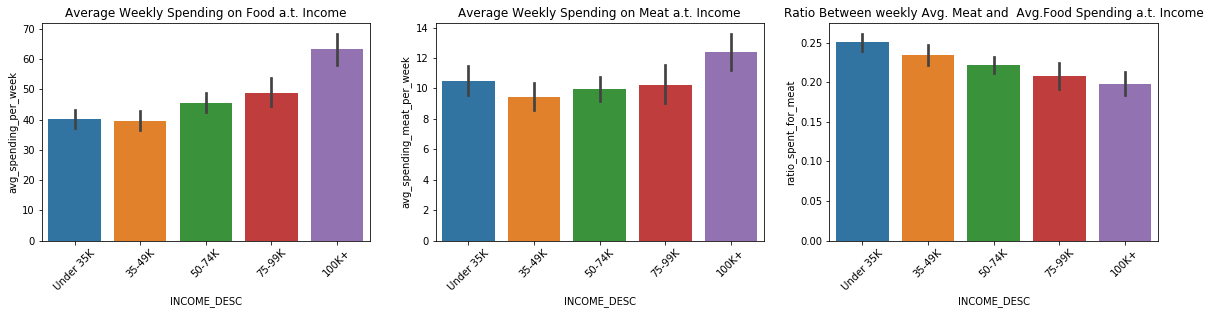

In [9]:
plot_weekly_spending(df_spent_and_demog, 'INCOME_DESC', 'Income', order=["Under 35K", "35-49K", "50-74K", "75-99K", "100K+"])

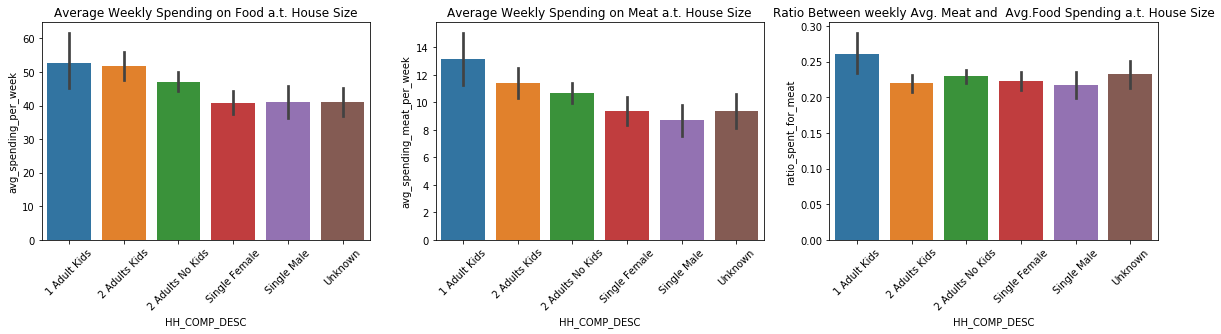

In [10]:
plot_weekly_spending(df_spent_and_demog, 'HH_COMP_DESC', 'House Size')

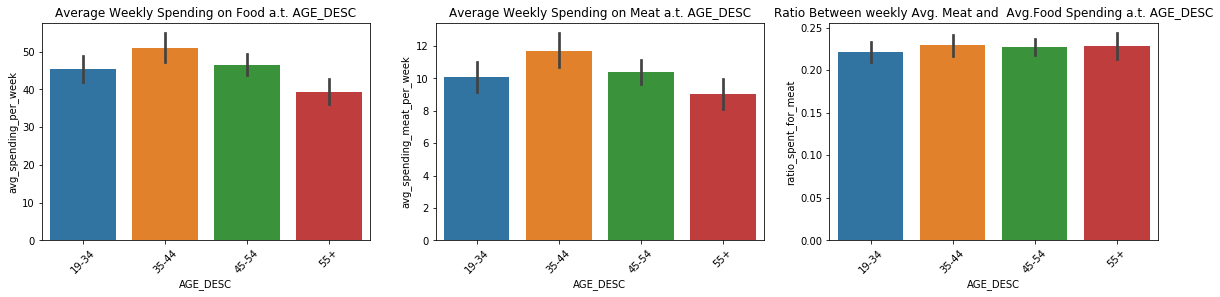

In [11]:
plot_weekly_spending(df_spent_and_demog, 'AGE_DESC', 'AGE_DESC')

In [12]:
df_household.columns

Index(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC',
       'household_key'],
      dtype='object')

In [13]:
def threshold_groups(df, threshold, KEY):
    valid_indices = df.groupby([KEY[0], KEY[1]]).count()['household_key'] >= threshold
    for k0, k1 in valid_indices.index:
        if not valid_indices[k0][k1]:
            df = df[(df[KEY[0]] != k0) | (df[KEY[1]] != k1)]
    return df

def analysis_2d(df_spent_and_demog, KEY, THRESHOLD):
    COLS_OF_INTEREST = [
    "paid_meat",
    "paid_veggies",
    "number_of_active_weeks",
    "ratio_spent_for_meat",
    "ratio_spent_for_veggies",
    "avg_spending_per_week",
    ]
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,13))

    for i, col in enumerate(COLS_OF_INTEREST):

        df_dummy = threshold_groups(df_spent_and_demog, THRESHOLD, KEY)
        df_dummy = df_dummy.groupby([KEY[0], KEY[1]]).agg({col: 'mean'})\
                                     .reset_index().pivot(index= KEY[0], columns= KEY[1], values=col)

        sns.heatmap(df_dummy, annot=True, fmt=".04f", annot_kws={"size": 10}, cmap="YlGnBu", ax=axes[i // 3, i % 3])
        axes[i // 3, i % 3].set_title(col)
        b, t = axes[i // 3, i % 3].set_ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        axes[i // 3, i % 3].set_ylim(b, t) # update the ylim(bottom, top) values

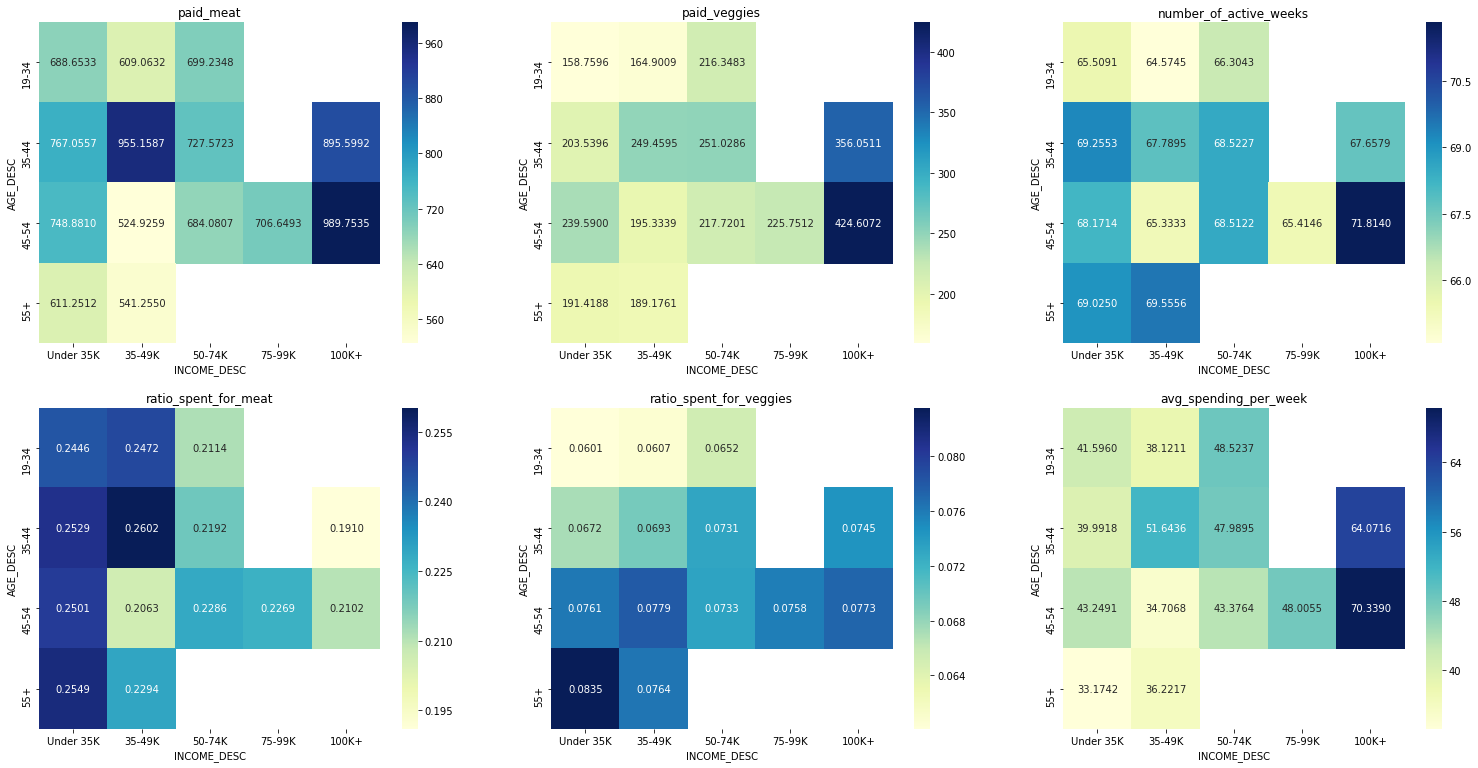

In [42]:
KEY  = ('AGE_DESC', 'INCOME_DESC')
THRESHOLD = 30,

analysis_2d(df_spent_and_demog, KEY, THRESHOLD)

In [ ]:
check the type of meat ocnsumed

In [15]:
df_household.columns

Index(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC',
       'household_key'],
      dtype='object')

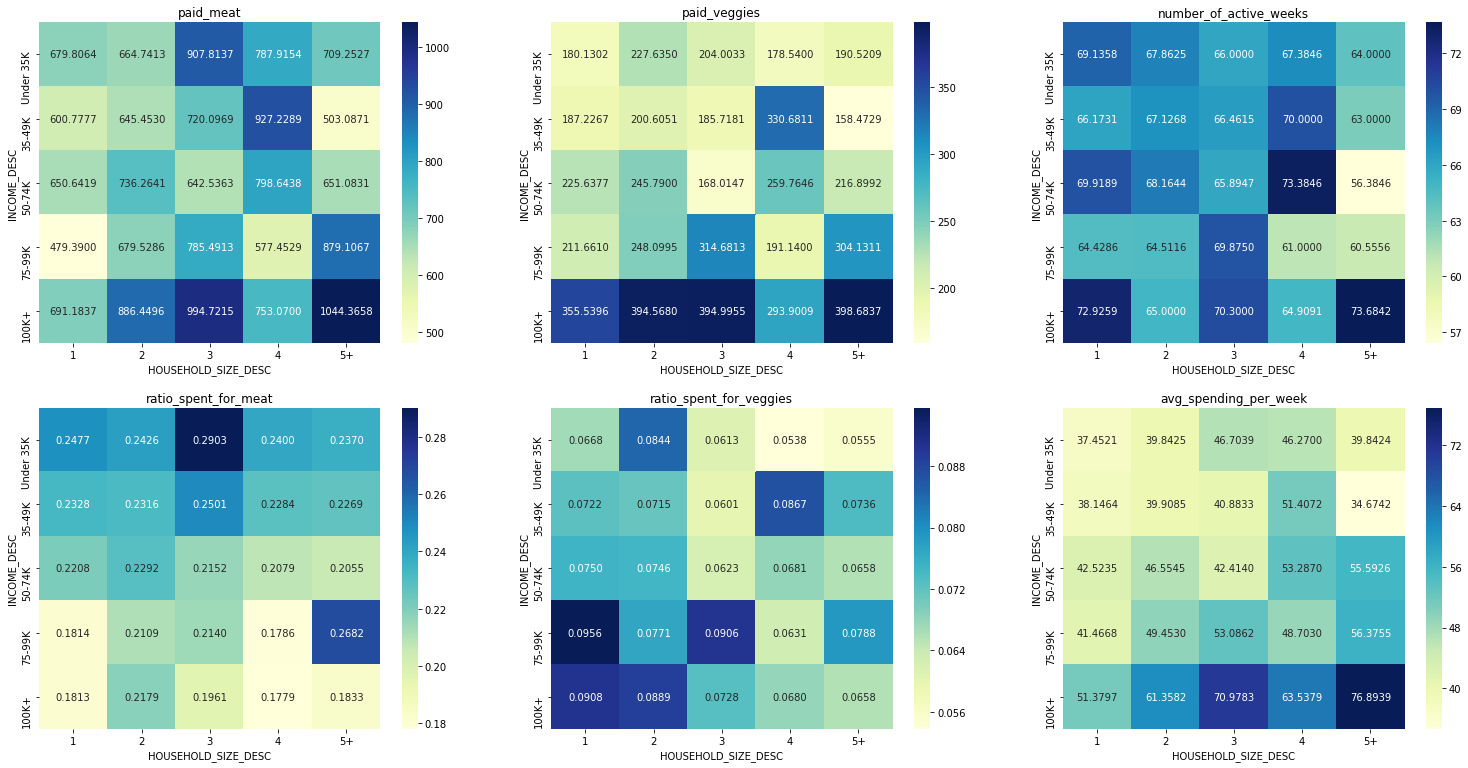

In [32]:
KEY  = ('INCOME_DESC', 'HOUSEHOLD_SIZE_DESC')
THRESHOLD = 0

analysis_2d(df_spent_and_demog, KEY, THRESHOLD)

In [23]:
# determıne ıf ratıo means that rıch people buy less meat or ıf they just buy more expensıve stuff. Check average meat concumptıon normalızed by number of actıve weeks